# Quicken Loans Case Study
Reza Parsi

 A portugese banking institution runs a direct marketing campaign based on phone calls.

 Client level data from 2008 to 2011 includes characteristics such as age, job, education, etc.

 How does the bank can maximize successful bank term deposits via phone calls?
 ⇨ ⇨ Binary Classification



# Results Summary

I used 4 models; Random Forest, Gradient Boosting, Logistic Regression, and Deep Learning (multi-layer feedforward artificial neural network)

The model performances are as follows:

RF AUC = 0.7387

GB AUC = 0.7328

LR AUC = 0.7351

DL AUC = 0.7205

The most important features are Month, Job, Age, Day, Poutcome, and Balance. 

The details of important features and coefficients (linear model) are provided within the model section. 



# Implementation

## 1) EDA & Data Check

### Continuous Variables

People younger than 30 and older than 60 tends to make deposits more than the rest of age groups.

People who have been contacted more recently seems to have higher chance of making deposits.



age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


NameError: name 'Print' is not defined

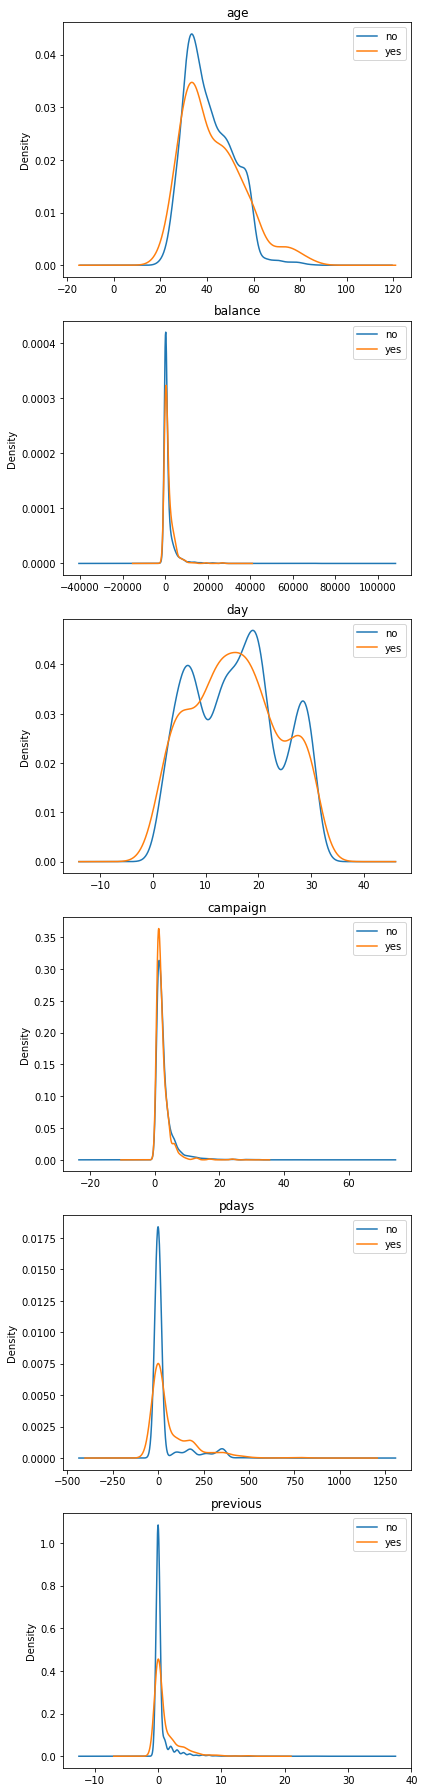

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os as os
import gc
data = pd.read_csv('bank.csv',sep = ';')

print(data.isnull().sum())

summary = data.describe()


features = ['age', 'balance', 'day', 'campaign', 'pdays','previous']

fig, axs = plt.subplots(nrows=6 , figsize=(6,25) )

for i,feature in enumerate(features):
    data.groupby("y")[feature].plot(kind='kde',legend=True,ax=axs[i])
    axs[i].set_title(feature)
plt.tight_layout()

Summary statistics of continuous variables.

In [7]:
print(summary)

               age       balance          day     duration     campaign  \
count  4521.000000   4521.000000  4521.000000  4521.000000  4521.000000   
mean     41.170095   1422.657819    15.915284   263.961292     2.793630   
std      10.576211   3009.638142     8.247667   259.856633     3.109807   
min      19.000000  -3313.000000     1.000000     4.000000     1.000000   
25%      33.000000     69.000000     9.000000   104.000000     1.000000   
50%      39.000000    444.000000    16.000000   185.000000     2.000000   
75%      49.000000   1480.000000    21.000000   329.000000     3.000000   
max      87.000000  71188.000000    31.000000  3025.000000    50.000000   

             pdays     previous  
count  4521.000000  4521.000000  
mean     39.766645     0.542579  
std     100.121124     1.693562  
min      -1.000000     0.000000  
25%      -1.000000     0.000000  
50%      -1.000000     0.000000  
75%      -1.000000     0.000000  
max     871.000000    25.000000  


### Categorical Variables

Job title seems to be a good predictor. As we can expect, retired and students are more likely to make deposits.
Moreover, blue-collar, entrepreneur, and unemployed are less likely to make deposits. 

Month will probably be a strong signal. December, March, October, and September are very promising for the marketing campaign.
May and July display unsuccessful attempts.
Portugal tax refunds start to be delivered in May  

Education, default seem to be weak signal in the prediction.  


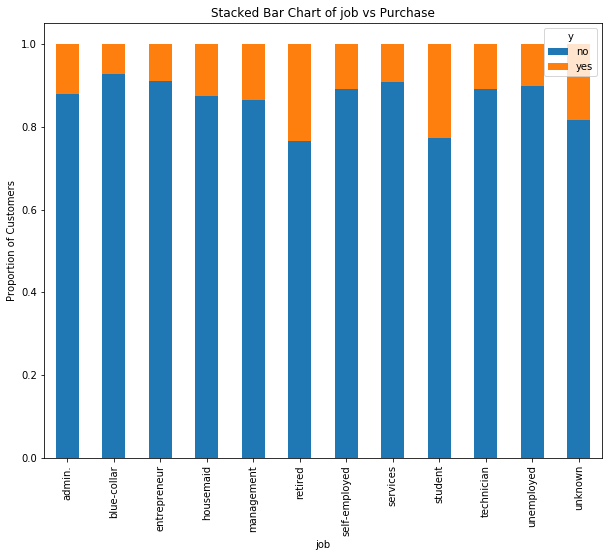

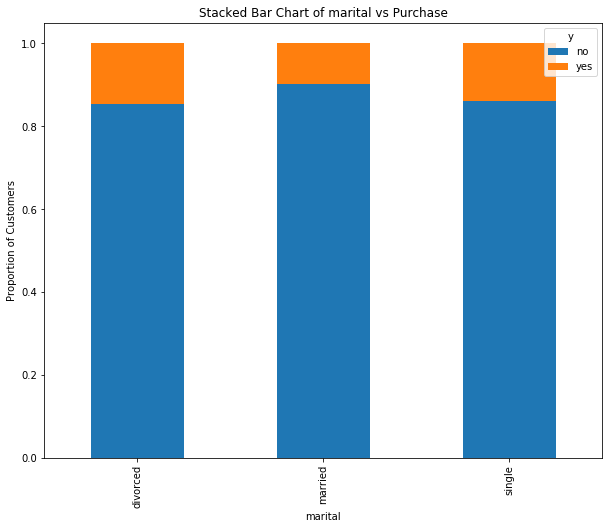

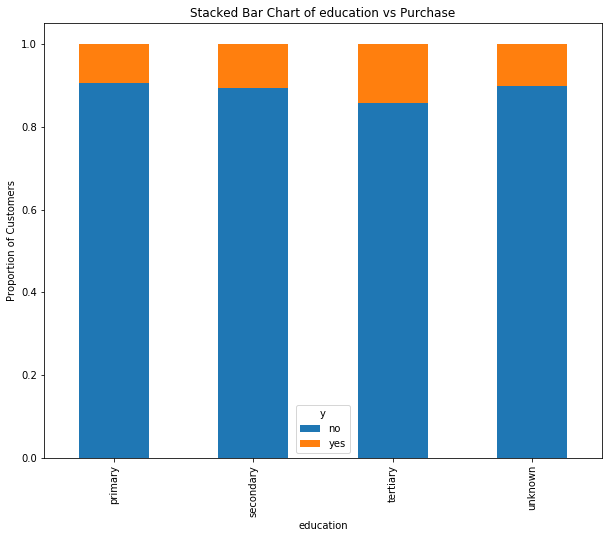

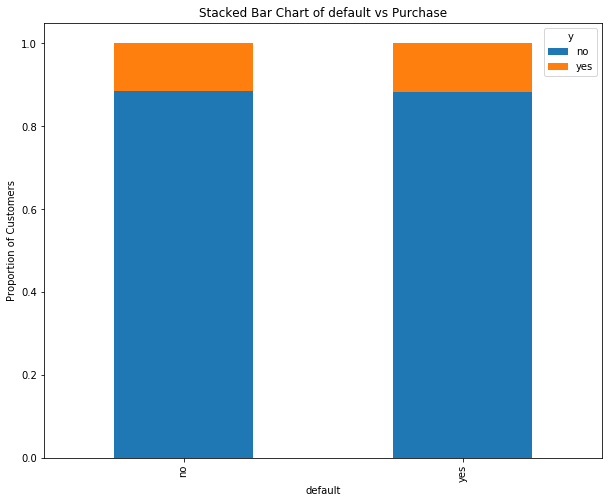

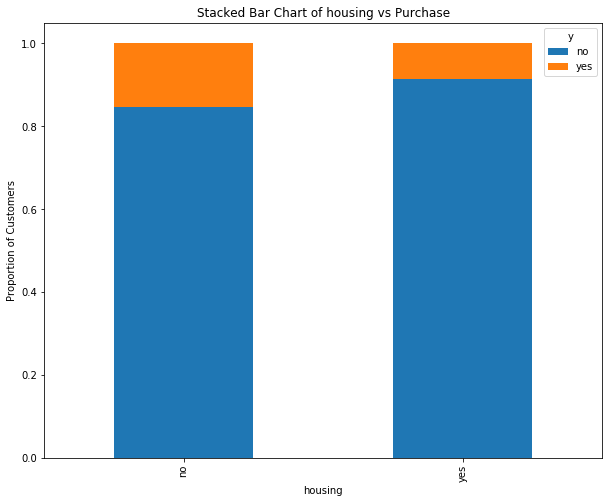

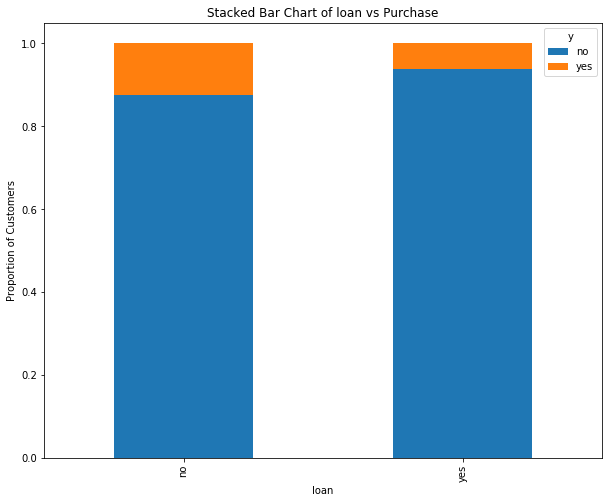

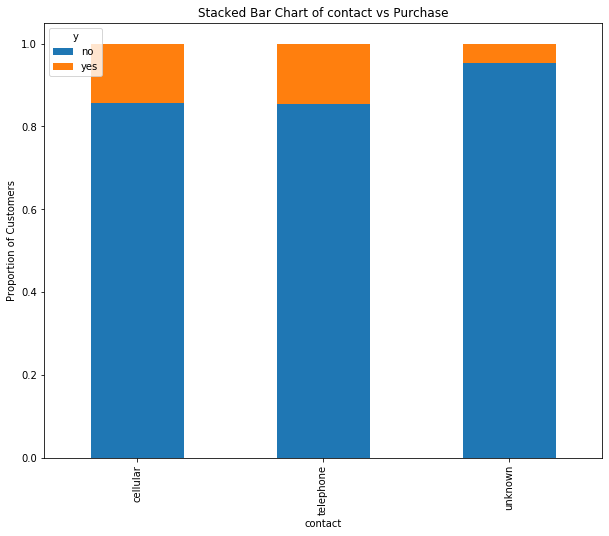

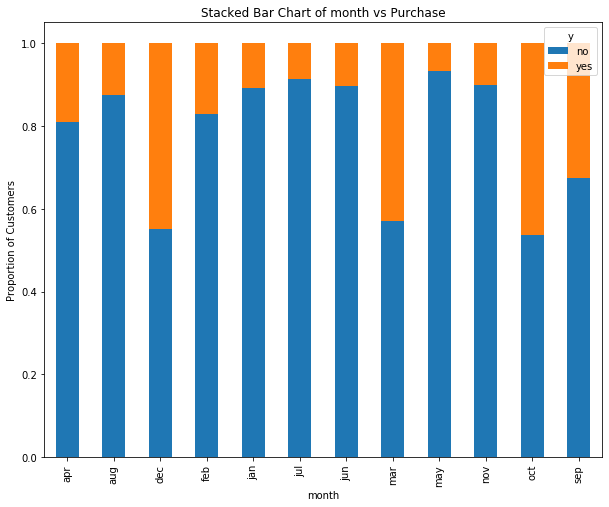

In [8]:
features2 = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month']


for feature2 in features2:
    table=pd.crosstab(data[feature2],data.y)
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.title('Stacked Bar Chart of ' + feature2 + ' vs Purchase')
    plt.xlabel(feature2)
    plt.ylabel('Proportion of Customers')
    plt.gcf().set_size_inches(10,8)

We do not see a strong correlation between continuous variables.

Text(0.5, 1.05, 'Pearson correlation of Features')

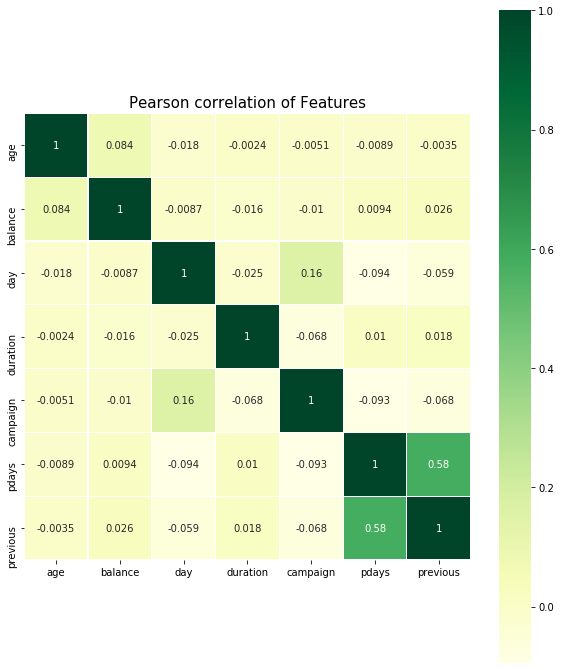

In [9]:
%matplotlib inline
corr = data.corr()

f, ax = plt.subplots(figsize=(10,12))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(corr, cmap="YlGn", square=True, ax=ax, annot=True, linewidth=0.1)

plt.title("Pearson correlation of Features", y=1.05, size=15)

Here I check if there is any duplication in the data, which there is None. 

In [12]:
data_dup = data[data.duplicated(keep='last')]
data_dup

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


## 2) Data Preprocessing 

Convertig the data to H2O data format.

Test, Train split.

Removing "duration" from dataset since it is not known before a call. In order to have a realistic predictive model, "duration" must be dropped.

In [17]:
import h2o

h2o.init(ip="localhost", port=54324, nthreads = -1,max_mem_size = 5 )

dataH2O = h2o.H2OFrame(data)

print(dataH2O.shape)

dataH2O['y'].levels()

splits = dataH2O.split_frame(ratios=[0.7], seed=1)  

train = splits[0]
# valid = splits[1]
test = splits[1]


y = 'y'
x = list(data.columns)
x.remove(y)  #remove the response
x.remove('duration')

Checking whether there is an H2O instance running at http://localhost:54324 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.1" 2018-10-16 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.1+13-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.1+13-LTS, mixed mode)
  Starting server from /Users/rezaparsi/opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1t/82c7y_j15yxclk_twp9ns2vh0000gn/T/tmpxi1d0byf
  JVM stdout: /var/folders/1t/82c7y_j15yxclk_twp9ns2vh0000gn/T/tmpxi1d0byf/h2o_rezaparsi_started_from_python.out
  JVM stderr: /var/folders/1t/82c7y_j15yxclk_twp9ns2vh0000gn/T/tmpxi1d0byf/h2o_rezaparsi_started_from_python.err
  Server is running at http://127.0.0.1:54326
Connecting to H2O server at http://127.0.0.1:54326 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_rezaparsi_48n1em
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
(4521, 17)


## 3) TSNE Visualization

In order to have 2-D visualization I Used a T-SNE plot for both train and test dataset.

Although there are some overlaps between the classes, it seems there are some distinctions.

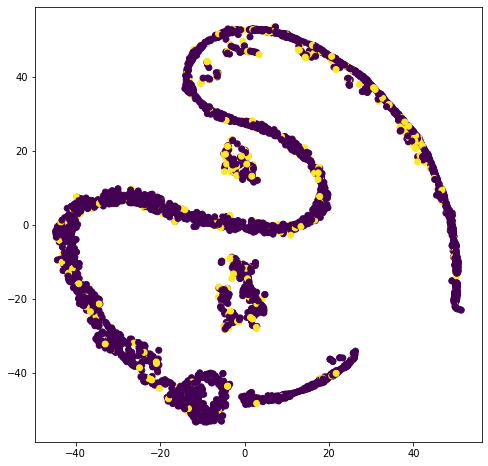

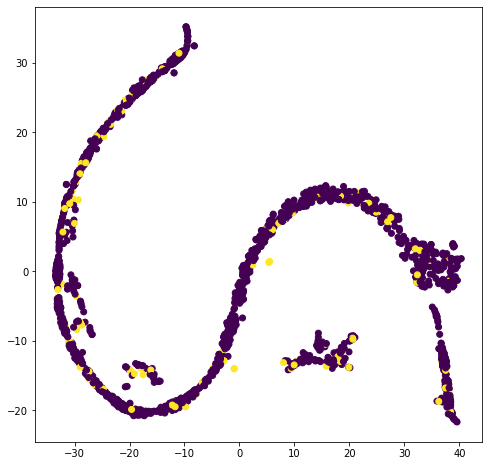

In [14]:

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.manifold import TSNE

rawData = train.as_data_frame()
X_train = rawData .drop(['y','duration'], axis=1)
Y_train = rawData['y'].replace(['yes','no'],[1,0])

rawData_test = test.as_data_frame()
X_test = rawData_test.drop(['y','duration'], axis=1)
Y_test = rawData_test['y'].replace(['yes','no'],[1,0])




encoded_columns = OneHotEncoder(sparse = False).fit_transform(X_train[features2])
processed_data = np.concatenate([X_train[features], encoded_columns], axis=1)

encoded_columns_test = OneHotEncoder(sparse = False).fit_transform(X_test[features2])
processed_data_test = np.concatenate([X_test[features], encoded_columns_test], axis=1)



TSNE_model = TSNE(n_components = 2, random_state = 1, perplexity = 50)

tsne_data = TSNE_model.fit_transform(processed_data)
plt.figure(figsize=(8,8))
plt.scatter(tsne_data[:,0],tsne_data[:,1], c = Y_train.values)
plt.show()


TSNE_model_test = TSNE(n_components = 2, random_state = 1, perplexity = 50)

tsne_data_test = TSNE_model.fit_transform(processed_data_test)
plt.figure(figsize=(8,8))
plt.scatter(tsne_data_test[:,0],tsne_data_test[:,1], c = Y_test.values)
plt.show()

## 4) Random Forest

### RF_Random Grid Search

I start with RF model. I use H2O library because the ataset contains many categorical variables. H2O can directly handle the data without OneHotEncoding. Also, it provides better tools for dimensionality reduction.

Here, I start with a default model, then I will use the random search and grid search function for hyper parameter tuning.

The AUC performance metric of Test dataset is as follows:

Default AUC = 0.7241

Random Search AUC = 0.7346

Grid Search AUC = 0.7387



In [48]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
rf_fit1_def = H2ORandomForestEstimator(model_id='rf_fit1_def', seed=1)

rf_fit1_def.train(x=x, y=y, training_frame=train)

rf_def_perf1 = rf_fit1_def.model_performance(test)

print(rf_def_perf1)

print('AUC test = '+ str(rf_def_perf1.auc()))
print('AUC train = '+ str(rf_fit1_def.auc(train = True)))


drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.08374702000649892
RMSE: 0.289390773879367
LogLoss: 0.30456502297503396
Mean Per-Class Error: 0.3089185841142128
AUC: 0.7241819163028013
AUCPR: 0.30385012531843053
Gini: 0.44836383260560253

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2147270910938581: 


,,no,yes,Error,Rate
0,no,1068.0,131.0,0.1093,(131.0/1199.0)
1,yes,71.0,65.0,0.5221,(71.0/136.0)
2,Total,1139.0,196.0,0.1513,(202.0/1335.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.214727,0.391566,132.0
1,max f2,0.160170,0.458237,181.0
2,max f0point5,0.310000,0.371622,81.0
3,max accuracy,0.608000,0.903371,14.0
4,max precision,0.832000,1.000000,0.0
5,max recall,0.001226,1.000000,397.0
6,max specificity,0.832000,1.000000,0.0
7,max absolute_mcc,0.214727,0.315096,132.0
8,max min_per_class_accuracy,0.119793,0.676471,226.0
9,max mean_per_class_accuracy,0.172175,0.691081,169.0



Gains/Lift Table: Avg response rate: 10.19 %, avg score: 12.14 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010487,0.616811,7.011555,7.011555,0.714286,0.733008,0.714286,0.733008,0.073529,0.073529,601.155462,601.155462,0.070193
1,2,0.020225,0.546461,3.775452,5.453431,0.384615,0.574178,0.555556,0.656534,0.036765,0.110294,277.545249,445.343137,0.100286
2,3,0.030712,0.496479,3.505777,4.788379,0.357143,0.516206,0.487805,0.608618,0.036765,0.147059,250.577731,378.837877,0.129544
3,4,0.040449,0.448457,1.510181,3.999183,0.153846,0.465645,0.407407,0.574198,0.014706,0.161765,51.018100,299.918301,0.135076
4,5,0.050187,0.415065,1.510181,3.516242,0.153846,0.428579,0.358209,0.545944,0.014706,0.176471,51.018100,251.624232,0.140607
5,6,0.100375,0.286958,3.369732,3.442987,0.343284,0.337481,0.350746,0.441712,0.169118,0.345588,236.973222,244.298727,0.273028
6,7,0.150562,0.210716,2.637182,3.174385,0.268657,0.242047,0.323383,0.375157,0.132353,0.477941,163.718174,217.438543,0.364513
7,8,0.200000,0.177495,1.041110,2.647059,0.106061,0.192174,0.269663,0.329926,0.051471,0.529412,4.110963,164.705882,0.366776
8,9,0.300375,0.131950,0.879061,2.056256,0.089552,0.153476,0.209476,0.270962,0.088235,0.617647,-12.093942,105.625642,0.353260
9,10,0.400000,0.108026,0.885670,1.764706,0.090226,0.119913,0.179775,0.233341,0.088235,0.705882,-11.432994,76.470588,0.340578




AUC test = 0.7241819163028013
AUC train = 0.7087784047441313


In [18]:
rf_params1 = {'ntrees': [i for i in range(50, 400,100)], 
                'max_depth': list(range(2, 50,10)),
                'nbins_cats': [i for i in range(2, 12,2)],
                'min_rows': [i for i in range(2, 50,10)]}

# Search criteria
search_criteria1 = {'strategy': 'RandomDiscrete', 'max_models': 40}

from h2o.estimators.random_forest import H2ORandomForestEstimator

from h2o.grid.grid_search import H2OGridSearch

rf_grid1 = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='rf_grid1',
                          hyper_params=rf_params1,
                          search_criteria=search_criteria1)

rf_grid1.train(x=x, y=y, 
                training_frame=train,  
                seed=1,balance_classes = True, binomial_double_trees =False, nfolds = 5)

rf_grid1perf = rf_grid1.get_grid(sort_by='auc', decreasing=True)

best_random_rf_model = rf_grid1perf.models[0]

best_random_rf_model_perf = best_random_rf_model.model_performance(test)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [20]:
print(best_random_rf_model_perf)

print('AUC test = '+ str(best_random_rf_model_perf.auc()))
print('AUC train = '+ str(best_random_rf_model.auc(train = True)))
print('AUC validation = '+ str(best_random_rf_model.auc(xval = True)))

print(''.join("\n{0} = {1}".format(i, best_random_rf_model.params[i]['actual']) for i in list(rf_params1.keys())))



ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.08169015488994934
RMSE: 0.2858148962002319
LogLoss: 0.2915211479869052
Mean Per-Class Error: 0.2947922288181327
AUC: 0.7346379335720944
AUCPR: 0.33880498096851996
Gini: 0.4692758671441888

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14491744915691324: 


,,no,yes,Error,Rate
0,no,1110.0,89.0,0.0742,(89.0/1199.0)
1,yes,82.0,54.0,0.6029,(82.0/136.0)
2,Total,1192.0,143.0,0.1281,(171.0/1335.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.144917,0.387097,110.0
1,max f2,0.083111,0.481675,210.0
2,max f0point5,0.310451,0.403226,27.0
3,max accuracy,0.321312,0.907865,24.0
4,max precision,0.750308,1.000000,0.0
5,max recall,0.011735,1.000000,392.0
6,max specificity,0.750308,1.000000,0.0
7,max absolute_mcc,0.144917,0.315753,110.0
8,max min_per_class_accuracy,0.076244,0.683824,223.0
9,max mean_per_class_accuracy,0.083111,0.705208,210.0



Gains/Lift Table: Avg response rate: 10.19 %, avg score:  7.98 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010487,0.433245,7.011555,7.011555,0.714286,0.527860,0.714286,0.527860,0.073529,0.073529,601.155462,601.155462,0.070193
1,2,0.020225,0.310902,6.795814,6.907680,0.692308,0.360580,0.703704,0.447318,0.066176,0.139706,579.581448,590.767974,0.133034
2,3,0.030712,0.281031,2.103466,5.267217,0.214286,0.292980,0.536585,0.394617,0.022059,0.161765,110.346639,426.721664,0.145918
3,4,0.040449,0.231131,2.265271,4.544526,0.230769,0.255342,0.462963,0.361088,0.022059,0.183824,126.527149,354.452614,0.159637
4,5,0.050187,0.212625,3.020362,4.248793,0.307692,0.219443,0.432836,0.333605,0.029412,0.213235,202.036199,324.879280,0.181542
5,6,0.100375,0.151991,3.076712,3.662752,0.313433,0.175280,0.373134,0.254442,0.154412,0.367647,207.671203,266.275241,0.297589
6,7,0.150562,0.118473,2.051141,3.125549,0.208955,0.131988,0.318408,0.213624,0.102941,0.470588,105.114135,212.554873,0.356326
7,8,0.200000,0.102936,1.487299,2.720588,0.151515,0.109237,0.277154,0.187821,0.073529,0.544118,48.729947,172.058824,0.383150
8,9,0.300375,0.084552,1.172081,2.203132,0.119403,0.093201,0.224439,0.156202,0.117647,0.661765,17.208077,120.313188,0.402382
9,10,0.400000,0.069812,0.295223,1.727941,0.030075,0.076292,0.176030,0.136299,0.029412,0.691176,-70.477665,72.794118,0.324204




AUC test = 0.7346379335720944
AUC train = 0.9462146314160268
AUC validation = 0.7454781919258892

ntrees = 350
max_depth = 42
nbins_cats = 10
min_rows = 12.0


### RF Grid Search

In [42]:
rf_params2 = {'ntrees': [300,350,400], 
                'max_depth': [30,42,50],
                'nbins_cats': [8,10,12],
                'min_rows': [10,12,14]}

search_criteria2 = {'strategy': 'RandomDiscrete', 'max_models' : 50}


rf_grid2 = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='rf_grid7',
                          hyper_params=rf_params2,
                          search_criteria = search_criteria2)
    
rf_grid2.train(x=x, y=y, 
                training_frame=train,  
                seed=1,balance_classes = True, nfolds = 3)

rf_grid2perf = rf_grid2.get_grid(sort_by='auc', decreasing=True)

best_random_rf_model = rf_grid2perf.models[0]

best_random_rf_model_perf = best_random_rf_model.model_performance(test)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [43]:
print(best_random_rf_model_perf)

print('AUC test = '+ str(best_random_rf_model_perf.auc()))
print('AUC train = '+ str(best_random_rf_model.auc(train = True)))
print('AUC validation = '+ str(best_random_rf_model.auc(xval = True)))

print(''.join("\n{0} = {1}".format(i, best_random_rf_model.params[i]['actual']) for i in list(rf_params2.keys())))



ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.08200473306624173
RMSE: 0.28636468543841387
LogLoss: 0.2920391332561379
Mean Per-Class Error: 0.30262964234901635
AUC: 0.7387651474267772
AUCPR: 0.32535512493425733
Gini: 0.47753029485355447

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12814979850476008: 


,,no,yes,Error,Rate
0,no,1093.0,106.0,0.0884,(106.0/1199.0)
1,yes,73.0,63.0,0.5368,(73.0/136.0)
2,Total,1166.0,169.0,0.1341,(179.0/1335.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.128150,0.413115,122.0
1,max f2,0.086305,0.467290,182.0
2,max f0point5,0.220740,0.404412,59.0
3,max accuracy,0.373898,0.905618,16.0
4,max precision,0.804326,1.000000,0.0
5,max recall,0.010292,1.000000,387.0
6,max specificity,0.804326,1.000000,0.0
7,max absolute_mcc,0.128150,0.340972,122.0
8,max min_per_class_accuracy,0.067569,0.669118,222.0
9,max mean_per_class_accuracy,0.086305,0.697370,182.0



Gains/Lift Table: Avg response rate: 10.19 %, avg score:  7.47 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010487,0.397514,7.011555,7.011555,0.714286,0.534322,0.714286,0.534322,0.073529,0.073529,601.155462,601.155462,0.070193
1,2,0.020225,0.312904,4.530543,5.816993,0.461538,0.346362,0.592593,0.443822,0.044118,0.117647,353.054299,481.699346,0.108473
2,3,0.030712,0.278203,2.103466,4.548960,0.214286,0.294546,0.463415,0.392850,0.022059,0.139706,110.346639,354.895983,0.121357
3,4,0.040449,0.247603,4.530543,4.544526,0.461538,0.262324,0.462963,0.361427,0.044118,0.183824,353.054299,354.452614,0.159637
4,5,0.050187,0.221337,5.285633,4.688323,0.538462,0.236301,0.477612,0.337149,0.051471,0.235294,428.563348,368.832309,0.206103
5,6,0.100375,0.146169,2.930202,3.809263,0.298507,0.177134,0.388060,0.257142,0.147059,0.382353,193.020193,280.926251,0.313963
6,7,0.150562,0.112122,2.197651,3.272059,0.223881,0.128051,0.333333,0.214111,0.110294,0.492647,119.765145,227.205882,0.380887
7,8,0.200000,0.094532,0.892380,2.683824,0.090909,0.102475,0.273408,0.186516,0.044118,0.536765,-10.762032,168.382353,0.374963
8,9,0.300375,0.074020,1.025571,2.129694,0.104478,0.082561,0.216958,0.151778,0.102941,0.639706,2.557068,112.969415,0.377821
9,10,0.400000,0.062345,0.664253,1.764706,0.067669,0.067993,0.179775,0.130910,0.066176,0.705882,-33.574746,76.470588,0.340578




AUC test = 0.7387651474267772
AUC train = 0.9584438077698968
AUC validation = 0.7411722158598274

ntrees = 350
max_depth = 50
nbins_cats = 12
min_rows = 10.0


Here I tried to increase the performance by using "binomial_double_trees" but it did not help.

In classification models, this option builds twice as many internal trees as the number of trees (one per class).

In [46]:
rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1', seed=1, balance_classes = True, ntrees = 350, 
                                   nfolds = 3,nbins_cats = 12,
                                   max_depth = 25, min_rows = 10,
                                   mtries = -1,binomial_double_trees =False)

rf_fit1.train(x=x, y=y, training_frame=train)

rf_perf1 = rf_fit1.model_performance(test)

drf Model Build progress: |███████████████████████████████████████████████| 100%



ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.08200186130061142
RMSE: 0.286359671218926
LogLoss: 0.2920033932162862
Mean Per-Class Error: 0.3030466565274984
AUC: 0.7389307265858804
AUCPR: 0.3253953432464253
Gini: 0.4778614531717609

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12814979850476008: 


,,no,yes,Error,Rate
0,no,1093.0,106.0,0.0884,(106.0/1199.0)
1,yes,73.0,63.0,0.5368,(73.0/136.0)
2,Total,1166.0,169.0,0.1341,(179.0/1335.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.128150,0.413115,122.0
1,max f2,0.086188,0.466744,181.0
2,max f0point5,0.220740,0.404412,59.0
3,max accuracy,0.373898,0.905618,16.0
4,max precision,0.804326,1.000000,0.0
5,max recall,0.010292,1.000000,387.0
6,max specificity,0.804326,1.000000,0.0
7,max absolute_mcc,0.128150,0.340972,122.0
8,max min_per_class_accuracy,0.067829,0.669118,223.0
9,max mean_per_class_accuracy,0.086188,0.696953,181.0



Gains/Lift Table: Avg response rate: 10.19 %, avg score:  7.47 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010487,0.397514,7.011555,7.011555,0.714286,0.534322,0.714286,0.534322,0.073529,0.073529,601.155462,601.155462,0.070193
1,2,0.020225,0.312904,4.530543,5.816993,0.461538,0.346362,0.592593,0.443822,0.044118,0.117647,353.054299,481.699346,0.108473
2,3,0.030712,0.278203,2.103466,4.548960,0.214286,0.294546,0.463415,0.392850,0.022059,0.139706,110.346639,354.895983,0.121357
3,4,0.040449,0.247603,4.530543,4.544526,0.461538,0.262324,0.462963,0.361427,0.044118,0.183824,353.054299,354.452614,0.159637
4,5,0.050187,0.221337,5.285633,4.688323,0.538462,0.236301,0.477612,0.337149,0.051471,0.235294,428.563348,368.832309,0.206103
5,6,0.100375,0.146169,2.930202,3.809263,0.298507,0.177125,0.388060,0.257137,0.147059,0.382353,193.020193,280.926251,0.313963
6,7,0.150562,0.112154,2.197651,3.272059,0.223881,0.128052,0.333333,0.214109,0.110294,0.492647,119.765145,227.205882,0.380887
7,8,0.200000,0.094247,0.892380,2.683824,0.090909,0.102475,0.273408,0.186514,0.044118,0.536765,-10.762032,168.382353,0.374963
8,9,0.300375,0.074020,1.025571,2.129694,0.104478,0.082556,0.216958,0.151775,0.102941,0.639706,2.557068,112.969415,0.377821
9,10,0.400000,0.062345,0.664253,1.764706,0.067669,0.067985,0.179775,0.130906,0.066176,0.705882,-33.574746,76.470588,0.340578




AUC test = 0.7389307265858804
AUC train = 0.9584193616402539
AUC validation = 0.7411722158598274


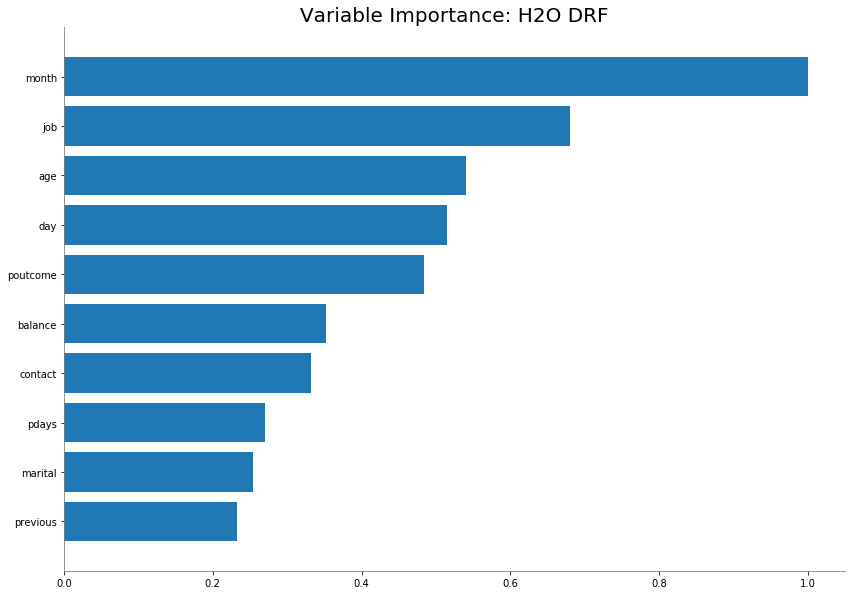

None


In [47]:
print(rf_perf1)

print('AUC test = '+ str(rf_perf1.auc()))
print('AUC train = '+ str(rf_fit1.auc(train = True)))
print('AUC validation = '+ str(rf_fit1.auc(xval = True)))

print(rf_fit1.varimp_plot())

## 5) GLM-Logistic Regression

I use a linear classification model. First, I utilize a defaults logistic model with no regularization therefore, the model drops one dummy variable (perfect multi collinearity).

Second, I use elastic net regularization (combination of L1 and L2). The P-value and coefficients are reported.



The AUC performance metric of Test dataset is as follows:

Default AUC = 0.7237

With Regularization AUC = 0.7328

In [25]:
splits2 = dataH2O.split_frame(ratios=[0.7, 0.15], seed=1)  

train2 = splits2[0]
valid2 = splits2[1]
test2 = splits2[2]

from h2o.estimators.glm import H2OGeneralizedLinearEstimator

glm_fit1 = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_fit1',
                                         lambda_ = 0,remove_collinear_columns = True,
                                         compute_p_values= True)

glm_fit1.train(x=x, y=y, training_frame=train2, validation_frame=valid2)

glm_perf1 = glm_fit1.model_performance(test2)

glm Model Build progress: |███████████████████████████████████████████████| 100%



ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.08444555930762981
RMSE: 0.290595181150049
LogLoss: 0.3010868967983515
Null degrees of freedom: 682
Residual degrees of freedom: 641
Null deviance: 465.6620633586603
Residual deviance: 411.2847010265482
AIC: 495.2847010265482
AUC: 0.7237255782618459
AUCPR: 0.3185748982155537
Gini: 0.44745115652369183

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2708667645985861: 


,,no,yes,Error,Rate
0,no,593.0,17.0,0.0279,(17.0/610.0)
1,yes,52.0,21.0,0.7123,(52.0/73.0)
2,Total,645.0,38.0,0.101,(69.0/683.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.270867,0.378378,34.0
1,max f2,0.095216,0.457686,205.0
2,max f0point5,0.315677,0.492228,26.0
3,max accuracy,0.407439,0.906296,20.0
4,max precision,0.678456,0.714286,6.0
5,max recall,0.023037,1.000000,375.0
6,max specificity,0.932512,0.998361,0.0
7,max absolute_mcc,0.315677,0.365222,26.0
8,max min_per_class_accuracy,0.100424,0.630137,196.0
9,max mean_per_class_accuracy,0.095216,0.671210,205.0



Gains/Lift Table: Avg response rate: 10.69 %, avg score: 35.06 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010249,0.646105,1.336595,1.336595,0.142857,0.792414,0.142857,0.792414,0.013699,0.013699,33.659491,33.659491,0.003863
1,2,0.020498,0.590286,2.673190,2.004892,0.285714,0.617888,0.214286,0.705151,0.027397,0.041096,167.318982,100.489237,0.023063
2,3,0.030747,0.573619,1.336595,1.782127,0.142857,0.579931,0.190476,0.663411,0.013699,0.054795,33.659491,78.212655,0.026926
3,4,0.040996,0.546533,0.000000,1.336595,0.000000,0.558416,0.142857,0.637162,0.000000,0.054795,-100.000000,33.659491,0.015450
4,5,0.051245,0.527332,2.673190,1.603914,0.285714,0.539232,0.171429,0.617576,0.027397,0.082192,167.318982,60.391389,0.034651
5,6,0.101025,0.474395,0.825544,1.220369,0.088235,0.492548,0.130435,0.555968,0.041096,0.123288,-17.445608,22.036927,0.024927
6,7,0.150805,0.441886,1.926269,1.453385,0.205882,0.457011,0.155340,0.523303,0.095890,0.219178,92.626914,45.338476,0.076555
7,8,0.200586,0.420378,1.100725,1.365863,0.117647,0.431334,0.145985,0.500478,0.054795,0.273973,10.072522,36.586341,0.082169
8,9,0.300146,0.380194,1.651088,1.460474,0.176471,0.402175,0.156098,0.467871,0.164384,0.438356,65.108783,46.047444,0.154750
9,10,0.399707,0.347269,1.788678,1.542225,0.191176,0.364830,0.164835,0.442205,0.178082,0.616438,78.867849,54.222490,0.242668




AUC test = 0.7237255782618459
AUC train = 0.7503901667771714
AUC validation = None

Coefficients: glm coefficients


,names,coefficients,std_error,z_value,p_value,standardized_coefficients
0,Intercept,-1.256312,0.627198,-2.003056,0.045171,-1.163701
1,job.blue-collar,-0.393659,0.247565,-1.590122,0.111807,-0.393659
2,job.entrepreneur,-0.123257,0.384763,-0.320345,0.748707,-0.123257
3,job.housemaid,-0.356022,0.430569,-0.826864,0.408314,-0.356022
4,job.management,-0.158505,0.247218,-0.641155,0.521422,-0.158505
5,job.retired,0.495073,0.310480,1.594540,0.110815,0.495073
6,job.self-employed,-0.359493,0.377375,-0.952617,0.340784,-0.359493
7,job.services,-0.185896,0.273673,-0.679264,0.496970,-0.185896
8,job.student,-0.210932,0.420420,-0.501717,0.615867,-0.210932
9,job.technician,-0.427209,0.236451,-1.806756,0.070800,-0.427209



See the whole table with table.as_data_frame()



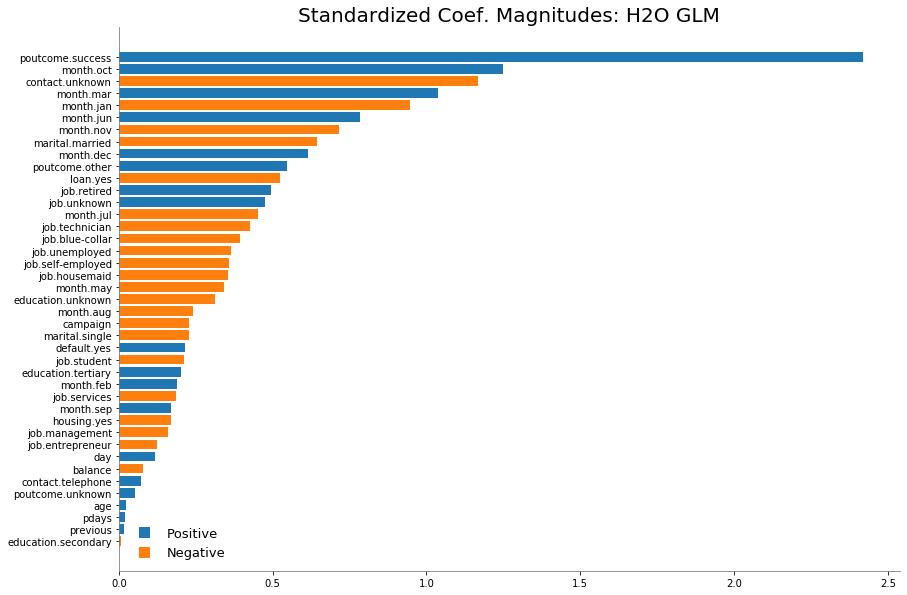

None


In [26]:
print(glm_perf1)

print('AUC test = '+ str(glm_perf1.auc()))
print('AUC train = '+ str(glm_fit1.auc(train = True)))
print('AUC validation = '+ str(glm_fit1.auc(xval = True)))


print(glm_fit1._model_json['output']['coefficients_table'])

print(glm_fit1.std_coef_plot())

### GLM with Regularization (Elastic Net)

In [28]:
glm_fit1_reg = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_fit1_reg',
                                         lambda_search = True)

glm_fit1_reg.train(x=x, y=y, training_frame=train2, validation_frame=valid2)

glm_reg_perf1 = glm_fit1_reg.model_performance(test2)

glm Model Build progress: |███████████████████████████████████████████████| 100%



ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.08451795053658985
RMSE: 0.29071971129696356
LogLoss: 0.29912102914967403
Null degrees of freedom: 682
Residual degrees of freedom: 648
Null deviance: 465.6620633586603
Residual deviance: 408.5993258184549
AIC: 478.5993258184549
AUC: 0.7328205704019761
AUCPR: 0.32549475573780456
Gini: 0.46564114080395225

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17355758580718708: 


,,no,yes,Error,Rate
0,no,550.0,60.0,0.0984,(60.0/610.0)
1,yes,42.0,31.0,0.5753,(42.0/73.0)
2,Total,592.0,91.0,0.1493,(102.0/683.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.173558,0.378049,81.0
1,max f2,0.125827,0.456389,155.0
2,max f0point5,0.320152,0.508475,23.0
3,max accuracy,0.338510,0.907760,21.0
4,max precision,0.338510,0.708333,21.0
5,max recall,0.027679,1.000000,379.0
6,max specificity,0.870437,0.998361,0.0
7,max absolute_mcc,0.320152,0.376939,23.0
8,max min_per_class_accuracy,0.112162,0.657534,185.0
9,max mean_per_class_accuracy,0.125827,0.680350,155.0



Gains/Lift Table: Avg response rate: 10.69 %, avg score: 11.44 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010249,0.613205,5.346380,5.346380,0.571429,0.712398,0.571429,0.712398,0.054795,0.054795,434.637965,434.637965,0.049876
1,2,0.020498,0.478083,6.682975,6.014677,0.714286,0.539543,0.642857,0.625971,0.068493,0.123288,568.297456,501.467710,0.115091
2,3,0.030747,0.348299,6.682975,6.237443,0.714286,0.406194,0.666667,0.552712,0.068493,0.191781,568.297456,523.744292,0.180305
3,4,0.040996,0.307651,5.346380,6.014677,0.571429,0.327451,0.642857,0.496397,0.054795,0.246575,434.637965,501.467710,0.230182
4,5,0.051245,0.265258,2.673190,5.346380,0.285714,0.274819,0.571429,0.452081,0.027397,0.273973,167.318982,434.637965,0.249382
5,6,0.101025,0.189362,1.651088,3.525511,0.176471,0.212254,0.376812,0.333906,0.082192,0.356164,65.108783,252.551122,0.285673
6,7,0.150805,0.166267,1.375907,2.815933,0.147059,0.178509,0.300971,0.282610,0.068493,0.424658,37.590653,181.593297,0.306625
7,8,0.200586,0.150029,1.651088,2.526847,0.176471,0.157399,0.270073,0.251535,0.082192,0.506849,65.108783,152.684732,0.342915
8,9,0.300146,0.124418,1.100725,2.053792,0.117647,0.135742,0.219512,0.213126,0.109589,0.616438,10.072522,105.379218,0.354143
9,10,0.399707,0.107052,0.412772,1.645040,0.044118,0.114589,0.175824,0.188582,0.041096,0.657534,-58.722804,64.503989,0.288682




AUC test = 0.7328205704019761
AUC train = 0.748802143946735
AUC validation = None

Coefficients: glm coefficients


,names,coefficients,standardized_coefficients
0,Intercept,-1.544184,-1.409570
1,job.admin.,0.120409,0.120409
2,job.blue-collar,-0.190496,-0.190496
3,job.entrepreneur,0.000000,0.000000
4,job.housemaid,0.000000,0.000000
5,job.management,0.021170,0.021170
6,job.retired,0.489424,0.489424
7,job.self-employed,0.000000,0.000000
8,job.services,0.000000,0.000000
9,job.student,0.000000,0.000000



See the whole table with table.as_data_frame()



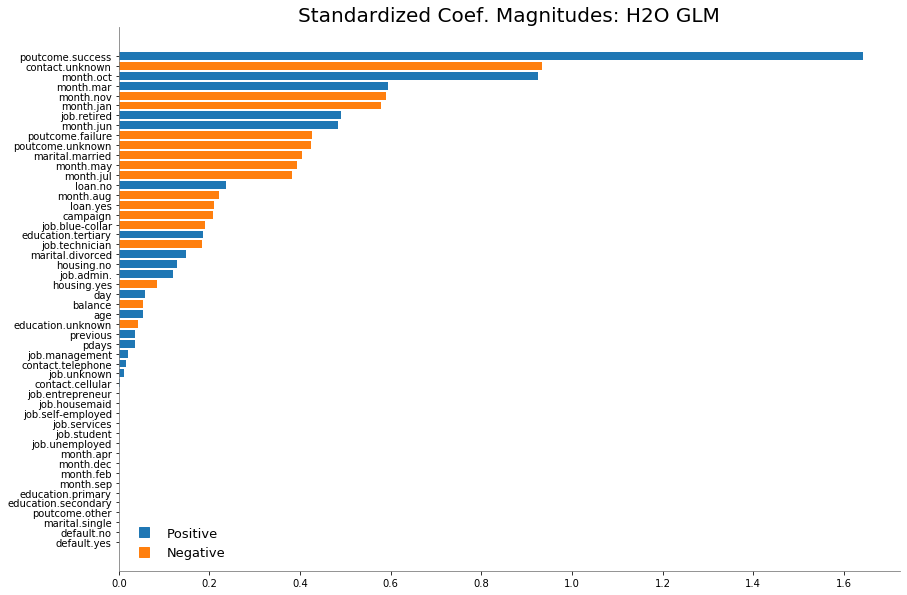

None


In [29]:
print(glm_reg_perf1)

print('AUC test = '+ str(glm_reg_perf1.auc()))
print('AUC train = '+ str(glm_fit1_reg.auc(train = True)))
print('AUC validation = '+ str(glm_fit1_reg.auc(xval = True)))


print(glm_fit1_reg._model_json['output']['coefficients_table'])

print(glm_fit1_reg.std_coef_plot())

## 6) Gradient Boosting

Similar to RF steps, I use Gradient Boosting method.

Default AUC = 0.7257

Grid Search AUC = 0.7351

In [32]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1, balance_classes = True,
                                        nfolds = 3,ntrees = 50)
gbm_fit1.train(x=x, y=y, training_frame=train)

gbm_perf1 = gbm_fit1.model_performance(test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [33]:
print(gbm_perf1)

print('AUC test = '+ str(gbm_perf1.auc()))
print('AUC train = '+ str(gbm_fit1.auc(train = True)))
print('AUC validation = '+ str(gbm_fit1.auc(xval = True)))


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.08314921762560867
RMSE: 0.2883560604974494
LogLoss: 0.29787498833269477
Mean Per-Class Error: 0.30741304027866356
AUC: 0.725742653191385
AUCPR: 0.2949461160429249
Gini: 0.45148530638276996

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.120137181155676: 


,,no,yes,Error,Rate
0,no,1030.0,169.0,0.141,(169.0/1199.0)
1,yes,67.0,69.0,0.4926,(67.0/136.0)
2,Total,1097.0,238.0,0.1768,(236.0/1335.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.120137,0.368984,145.0
1,max f2,0.087158,0.465116,201.0
2,max f0point5,0.177620,0.364583,88.0
3,max accuracy,0.468262,0.903371,19.0
4,max precision,0.794382,1.000000,0.0
5,max recall,0.008057,1.000000,398.0
6,max specificity,0.794382,1.000000,0.0
7,max absolute_mcc,0.120137,0.289564,145.0
8,max min_per_class_accuracy,0.080904,0.661765,215.0
9,max mean_per_class_accuracy,0.087158,0.692587,201.0



Gains/Lift Table: Avg response rate: 10.19 %, avg score:  8.46 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010487,0.535859,5.609244,5.609244,0.571429,0.655362,0.571429,0.655362,0.058824,0.058824,460.924370,460.924370,0.053819
1,2,0.020225,0.415433,5.285633,5.453431,0.538462,0.469730,0.555556,0.565984,0.051471,0.110294,428.563348,445.343137,0.100286
2,3,0.030712,0.362820,2.103466,4.309541,0.214286,0.389959,0.439024,0.505878,0.022059,0.132353,110.346639,330.954089,0.113170
3,4,0.040449,0.283350,3.020362,3.999183,0.307692,0.326910,0.407407,0.462793,0.029412,0.161765,202.036199,299.918301,0.135076
4,5,0.050187,0.245153,3.775452,3.955773,0.384615,0.261979,0.402985,0.423829,0.036765,0.198529,277.545249,295.577261,0.165168
5,6,0.100375,0.155686,2.637182,3.296477,0.268657,0.192888,0.335821,0.308358,0.132353,0.330882,163.718174,229.647717,0.256654
6,7,0.150562,0.128750,2.197651,2.930202,0.223881,0.139029,0.298507,0.251915,0.110294,0.441176,119.765145,193.020193,0.323578
7,8,0.200000,0.112379,1.784759,2.647059,0.181818,0.120541,0.269663,0.219441,0.088235,0.529412,78.475936,164.705882,0.366776
8,9,0.300375,0.087151,1.098826,2.129694,0.111940,0.099721,0.216958,0.179435,0.110294,0.639706,9.882572,112.969415,0.377821
9,10,0.400000,0.071983,0.516641,1.727941,0.052632,0.079102,0.176030,0.154445,0.051471,0.691176,-48.335913,72.794118,0.324204




AUC test = 0.725742653191385
AUC train = 0.9443712404526405
AUC validation = 0.6944064503864575


### Grid Search

In [34]:
from h2o.grid.grid_search import H2OGridSearch

gbm_params1 = {'learn_rate': [0.01, 0.1], 
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 1.0]}


gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid2',
                          hyper_params=gbm_params1)
gbm_grid1.train(x=x, y=y, 
                training_frame=train,  
                ntrees=50,max_depth = 25,nfolds = 3,
                seed=1,balance_classes = True)

gbm_gridperf1 = gbm_grid1.get_grid(sort_by='auc', decreasing=True)


best_gbm_model = gbm_gridperf1.models[0]

best_gbm_model_perf = best_gbm_model.model_performance(test)


gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [35]:
print(best_gbm_model_perf)

print('AUC test = '+ str(best_gbm_model_perf.auc()))
print('AUC train = '+ str(best_gbm_model.auc(train = True)))
print('AUC validation = '+ str(best_gbm_model.auc(xval = True)))

print(''.join("\n{0} = {1}".format(i, best_gbm_model.params[i]['actual']) for i in list(gbm_params1.keys())))




ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.08694964971777885
RMSE: 0.29487226000045996
LogLoss: 0.30677256396300373
Mean Per-Class Error: 0.2939827307069617
AUC: 0.7351162733650591
AUCPR: 0.3154339312335084
Gini: 0.4702325467301183

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10710907914548208: 


,,no,yes,Error,Rate
0,no,1023.0,176.0,0.1468,(176.0/1199.0)
1,yes,60.0,76.0,0.4412,(60.0/136.0)
2,Total,1083.0,252.0,0.1768,(236.0/1335.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.107109,0.391753,144.0
1,max f2,0.107109,0.477387,144.0
2,max f0point5,0.148210,0.400943,52.0
3,max accuracy,0.170892,0.903371,24.0
4,max precision,0.229541,1.000000,0.0
5,max recall,0.059226,1.000000,388.0
6,max specificity,0.229541,1.000000,0.0
7,max absolute_mcc,0.107109,0.318492,144.0
8,max min_per_class_accuracy,0.092171,0.669118,207.0
9,max mean_per_class_accuracy,0.107109,0.706017,144.0



Gains/Lift Table: Avg response rate: 10.19 %, avg score:  9.07 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010487,0.192594,5.609244,5.609244,0.571429,0.203663,0.571429,0.203663,0.058824,0.058824,460.924370,460.924370,0.053819
1,2,0.020225,0.176053,6.040724,5.816993,0.615385,0.182029,0.592593,0.193247,0.058824,0.117647,504.072398,481.699346,0.108473
2,3,0.030712,0.168169,4.206933,5.267217,0.428571,0.171415,0.536585,0.185792,0.044118,0.161765,320.693277,426.721664,0.145918
3,4,0.040449,0.154465,3.775452,4.908088,0.384615,0.161236,0.500000,0.179880,0.036765,0.198529,277.545249,390.808824,0.176011
4,5,0.050187,0.149404,3.775452,4.688323,0.384615,0.152183,0.477612,0.174506,0.036765,0.235294,277.545249,368.832309,0.206103
5,6,0.100375,0.126839,2.051141,3.369732,0.208955,0.136343,0.343284,0.155425,0.102941,0.338235,105.114135,236.973222,0.264841
6,7,0.150562,0.111476,2.490672,3.076712,0.253731,0.117773,0.313433,0.142874,0.125000,0.463235,149.067164,207.671203,0.348139
7,8,0.200000,0.104842,1.933489,2.794118,0.196970,0.108561,0.284644,0.134392,0.095588,0.558824,93.348930,179.411765,0.399524
8,9,0.300375,0.094722,0.805806,2.129694,0.082090,0.098950,0.216958,0.122549,0.080882,0.639706,-19.419447,112.969415,0.377821
9,10,0.400000,0.088330,0.442835,1.709559,0.045113,0.091565,0.174157,0.114832,0.044118,0.683824,-55.716497,70.955882,0.316017




AUC test = 0.7351162733650591
AUC train = 0.9936362395537359
AUC validation = 0.7350556619389179

learn_rate = 0.01
sample_rate = 0.8
col_sample_rate = 0.2


### Random Grid Search

In [36]:
gbm_params2 = {'learn_rate': [i * 0.01 for i in range(1, 11)], 
                'sample_rate': [i * 0.1 for i in range(5, 11)],
                'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria2 = {'strategy': 'RandomDiscrete', 'max_models': 50}

gbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid3',
                          hyper_params=gbm_params2,
                          search_criteria=search_criteria2)
gbm_grid2.train(x=x, y=y, 
                training_frame=train, 
                ntrees=50, max_depth = 25, nfolds = 3,
                seed=1,balance_classes = True)

gbm_gridperf2 = gbm_grid2.get_grid(sort_by='auc', decreasing=True)

best_gbm_model = gbm_gridperf2.models[0]

best_gbm_model_perf = best_gbm_model.model_performance(test)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%



ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.08374247389524567
RMSE: 0.28938291914908465
LogLoss: 0.3038825198735743
Mean Per-Class Error: 0.31722513859588874
AUC: 0.7270458224991414
AUCPR: 0.31021429804198153
Gini: 0.4540916449982828

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12672690801387917: 


,,no,yes,Error,Rate
0,no,1112.0,87.0,0.0726,(87.0/1199.0)
1,yes,84.0,52.0,0.6176,(84.0/136.0)
2,Total,1196.0,139.0,0.1281,(171.0/1335.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.126727,0.378182,108.0
1,max f2,0.048923,0.451056,246.0
2,max f0point5,0.247341,0.379213,48.0
3,max accuracy,0.381289,0.904869,15.0
4,max precision,0.602369,1.000000,0.0
5,max recall,0.011120,1.000000,386.0
6,max specificity,0.602369,1.000000,0.0
7,max absolute_mcc,0.126727,0.306815,108.0
8,max min_per_class_accuracy,0.049605,0.671393,243.0
9,max mean_per_class_accuracy,0.066433,0.682775,201.0



Gains/Lift Table: Avg response rate: 10.19 %, avg score:  6.28 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010487,0.393626,7.011555,7.011555,0.714286,0.503801,0.714286,0.503801,0.073529,0.073529,601.155462,601.155462,0.070193
1,2,0.020225,0.319321,4.530543,5.816993,0.461538,0.357552,0.592593,0.433385,0.044118,0.117647,353.054299,481.699346,0.108473
2,3,0.030712,0.282587,2.804622,4.788379,0.285714,0.297567,0.487805,0.387008,0.029412,0.147059,180.462185,378.837877,0.129544
3,4,0.040449,0.249465,4.530543,4.726307,0.461538,0.268730,0.481481,0.358534,0.044118,0.191176,353.054299,372.630719,0.167824
4,5,0.050187,0.218130,1.510181,4.102283,0.153846,0.232195,0.417910,0.334020,0.014706,0.205882,51.018100,310.228270,0.173355
5,6,0.100375,0.129042,3.076712,3.589497,0.313433,0.166333,0.365672,0.250176,0.154412,0.360294,207.671203,258.949737,0.289402
6,7,0.150562,0.099111,1.611611,2.930202,0.164179,0.113455,0.298507,0.204603,0.080882,0.441176,61.161106,193.020193,0.323578
7,8,0.200000,0.081821,1.189840,2.500000,0.121212,0.090020,0.254682,0.176279,0.058824,0.500000,18.983957,150.000000,0.334028
8,9,0.300375,0.059055,1.098826,2.031777,0.111940,0.068648,0.206983,0.140312,0.110294,0.610294,9.882572,103.177717,0.345073
9,10,0.400000,0.045957,0.959476,1.764706,0.097744,0.051897,0.179775,0.118291,0.095588,0.705882,-4.052410,76.470588,0.340578




AUC test = 0.7270458224991414
AUC train = 0.9962666176385956
AUC validation = 0.7409320418959833

learn_rate = 0.05
sample_rate = 0.5
col_sample_rate = 0.2


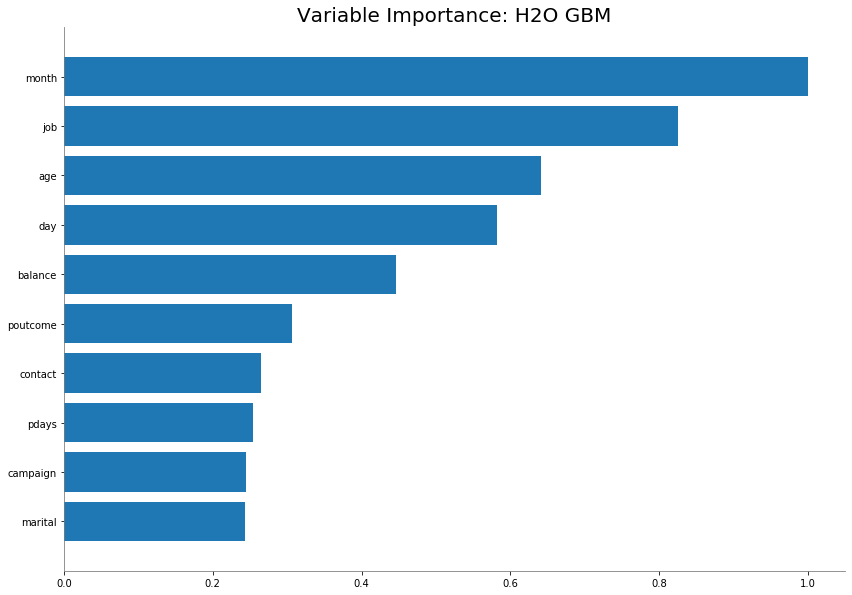

None


In [37]:
print(best_gbm_model_perf)

print('AUC test = '+ str(best_gbm_model_perf.auc()))
print('AUC train = '+ str(best_gbm_model.auc(train = True)))
print('AUC validation = '+ str(best_gbm_model.auc(xval = True)))

print(''.join("\n{0} = {1}".format(i, best_gbm_model.params[i]['actual']) for i in list(gbm_params2.keys())))


print(best_gbm_model.varimp_plot())


## 7) Deep Learning

First I train a basic DL model with default parameters. Second, I train a DL model with new architecture and more epochs. I increase the number of epochs to 20. Increasing the number of epochs may increase performance of the model, although, overfitting might be a problem.

Default AUC: 0.6650

New Architecture AUC: 0.7205

In [38]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

dl_fit1 = H2ODeepLearningEstimator(model_id='dl_fit1', seed=1 ,
                                   balance_classes = True, nfolds=3)
dl_fit1.train(x=x, y=y, training_frame=train)


dl_fit1_perf = dl_fit1.model_performance(test)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [39]:
print('AUC test = '+ str(dl_fit1_perf.auc()))
print('AUC train = '+ str(dl_fit1.auc(train = True)))
print('AUC validation = '+ str(dl_fit1.auc(xval = True)))

AUC test = 0.665021096011382
AUC train = 0.9788835096086022
AUC validation = 0.668534892454921


With train AUC = 0.97, clearly the DL model is overfitting.


### DL with Early Stopping and More Epochs

In [40]:

dl_fit2 = H2ODeepLearningEstimator(model_id='dl_fit2', 
                                   epochs=15,balance_classes = True,  nfolds=3,
                                   hidden=[20,20],
                                   score_interval=1,          #used for early stopping
                                   stopping_rounds=3,         #used for early stopping
                                   stopping_metric='AUC',     #used for early stopping
                                   stopping_tolerance=0.0005, #used for early stopping
                                   activation = 'TanhWithDropout',
                                   seed=1)

dl_fit2.train(x=x, y=y, training_frame=train)


dl_fit2_perf = dl_fit2.model_performance(test)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [41]:
print('AUC test = '+ str(dl_fit2_perf.auc()))
print('AUC train = '+ str(dl_fit2.auc(train = True)))
print('AUC validation = '+ str(dl_fit2.auc(xval = True)))

AUC test = 0.7205882352941176
AUC train = 0.757276415952933
AUC validation = 0.7086972648914812
